# Simple DAS plotting
This script aims for quick plotting of DAS data.

In [5]:
# import packages
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import sys
sys.path.append("../utils/")
import DASfuncs
import getDTSdata
from tqdm import tqdm

In [6]:
dts_time, dts_dist, dts_data = getDTSdata.getDTSdata()

In [7]:
# get files
t_start = datetime.datetime(2023,8,25)
t_end = datetime.datetime(2023,8,30)
path = '../data/DAS/data_1Hz'
files = DASfuncs.get_Onyx_h5(path, t_start, t_end)
print('{} files in directory'.format(len(files)))

112 files in directory


In [8]:
# read the data
time_read, data_read, attrs_read = DASfuncs.read_Onyx_h5_to_list(files, cha_start=None, cha_end=None, t_start=t_start, t_end=t_end, verbose=True)
# concatenate files
t_rec, data_rec, attrs = DASfuncs.comb_Onyx_data(time_read, data_read, attrs_read)

Problems with: ../data/DAS/data_1Hz/decimator3_2023-08-15_12.02.22_UTC.h5
Unable to open file (bad object header version number)


In [9]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')

In [10]:
# filtering
sos = scipy.signal.butter(2, 0.1,'lowpass', fs=attrs['PulseRate'], output='sos')
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

In [11]:
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

In [12]:
data_arr = data_filled
times = DASfuncs.sintela_to_datetime(t_rec)  # Convert timestamp to datetime
dx = attrs['SpatialSamplingInterval']
chas = np.arange(attrs['StartLocusIndex'], attrs['StartLocusIndex']+attrs['NumberOfLoci'])
dists = chas*dx

In [13]:
# Slice data in time and space
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = t_start
end_time = t_end

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = data_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]

In [14]:
data_norm = plot_arr #- np.nanmedian(plot_arr, axis=0)
# data_norm = data_norm / np.std(data_norm, axis=0)[None,:]
print(plot_times[0], plot_times[-1])

2023-08-25 00:13:10 2023-08-29 14:25:56


In [16]:
%matplotlib widget

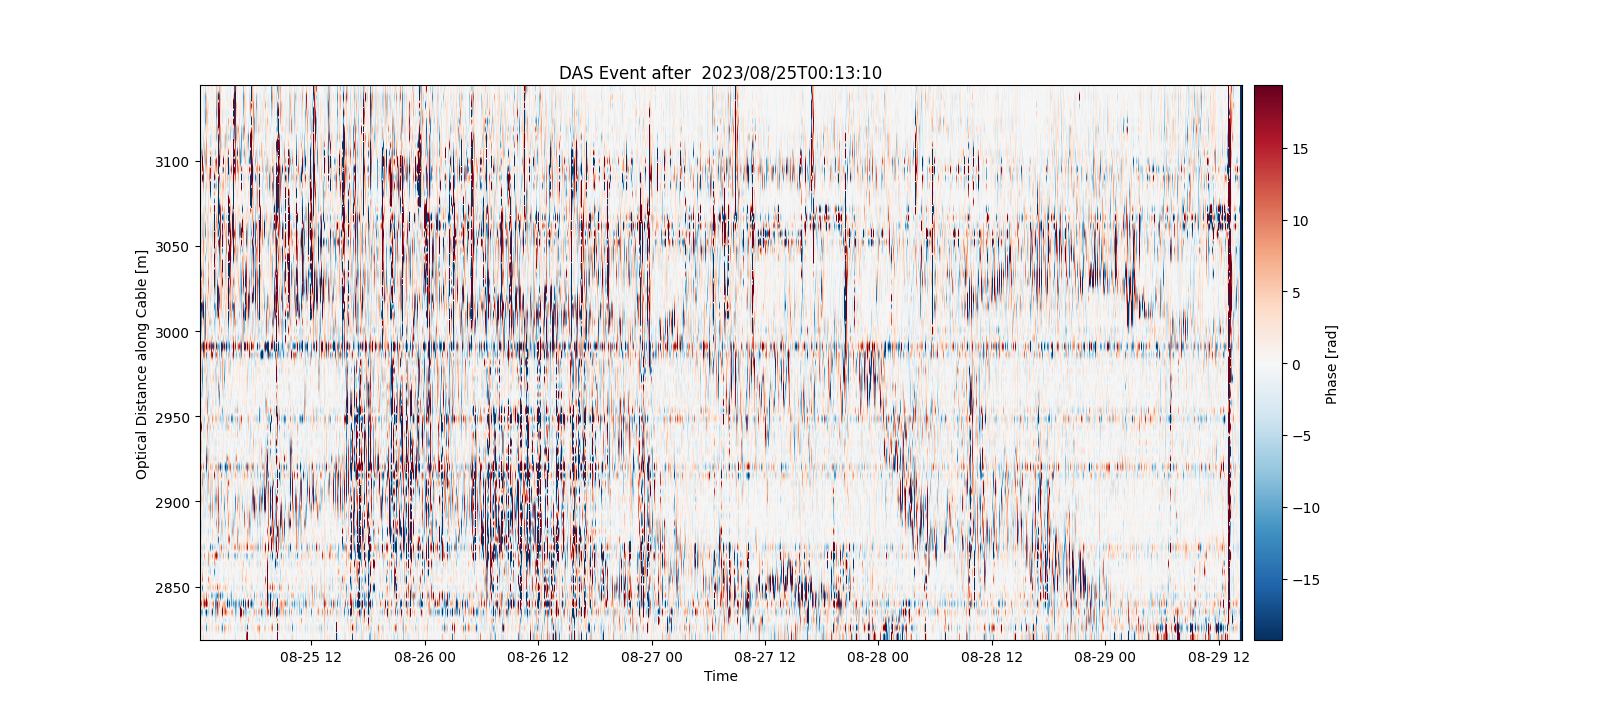

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(data_norm.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(data_norm[~np.isnan(data_norm)],5),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('DAS Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')


In [14]:
# Recall plot_times, plot_dists


dts_timeint = dts_time.astype(int)
das_timeint = pd.DatetimeIndex(plot_times)
das_timeint = das_timeint.astype(int)

points = (dts_timeint, dts_dist)
pointsinterp = (das_timeint, plot_dists)
dts_interp = np.empty(np.shape(data_norm))
print(np.shape(dts_interp), len(das_timeint), len(plot_dists))
points_interp = np.meshgrid(das_timeint, plot_dists)
dts_interp = scipy.interpolate.interpn(points, dts_data, points_interp, bounds_error=False)

(396767, 69) 396767 69


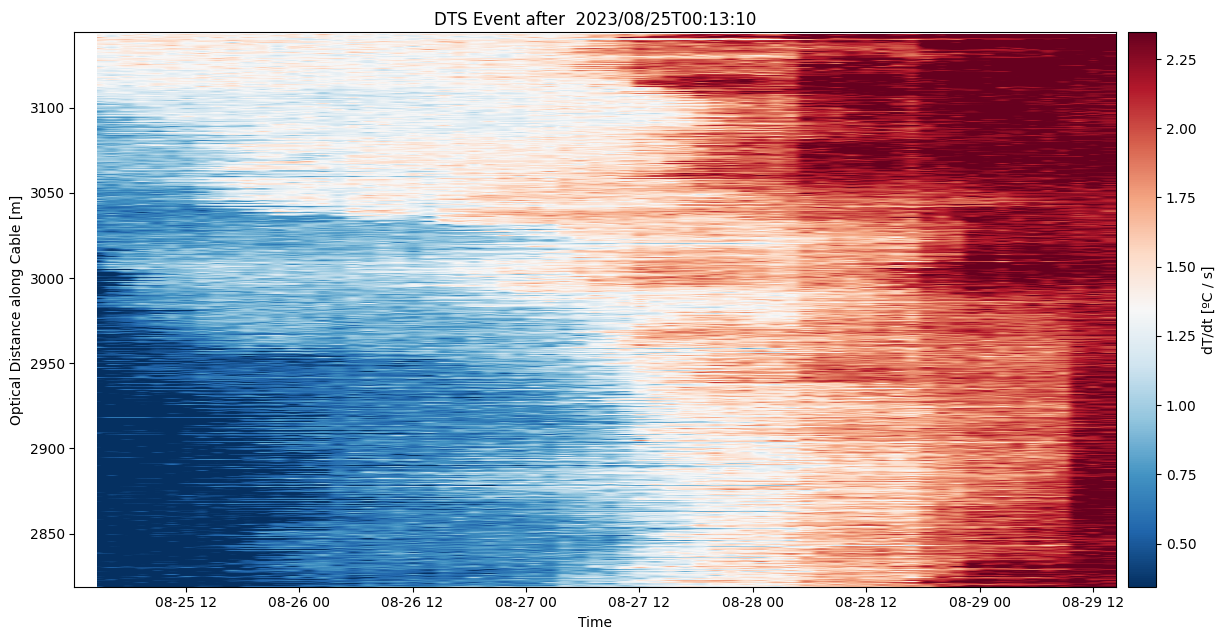

In [16]:
# Plot
fig2, ax2 = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im2 = ax2.imshow(dts_interp.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(dts_interp[~np.isnan(dts_interp)],5),
             vmax=np.percentile(dts_interp[~np.isnan(dts_interp)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax2.set_ylabel('Optical Distance along Cable [m]')
ax2.set_xlabel('Time')
ax2.set_title('DTS Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))
ax2.set_xlim(pd.to_datetime("2023-08-25 00:13:10"), pd.to_datetime("2023-08-29 14:25:56"))

cbar = fig2.colorbar(im2, pad=0.01)
cbar.set_label('dT/dt [ºC / s]')